In [1]:
import gzip
import yaml
import rich
import uproot
import correctionlib
import numpy as np
import mplhep as hep
import correctionlib.convert
import matplotlib.pyplot as plt
with open("../analysis/postprocess/style.yaml", "r") as f:
    style = yaml.safe_load(f)
plt.rcParams.update(style["rcParams"])

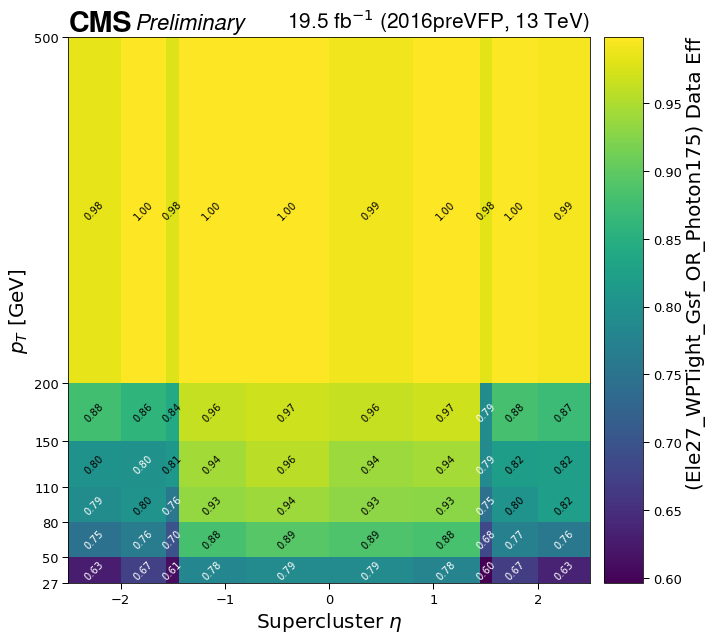

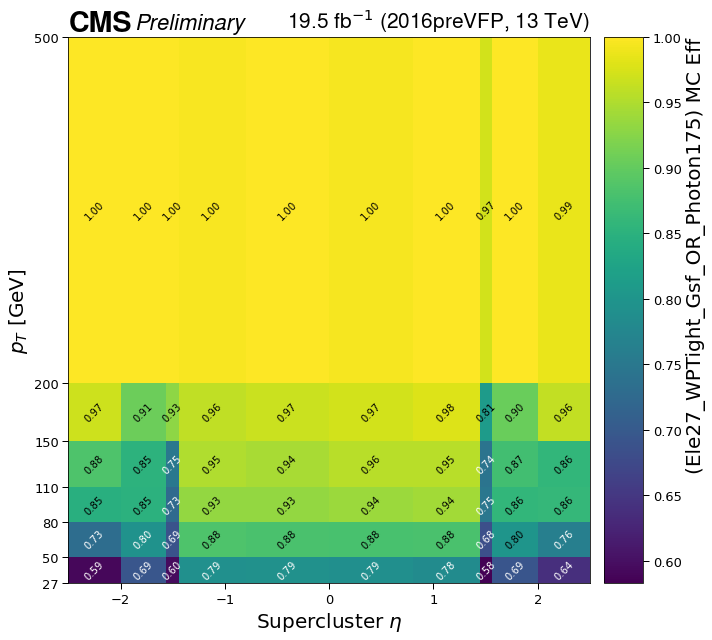

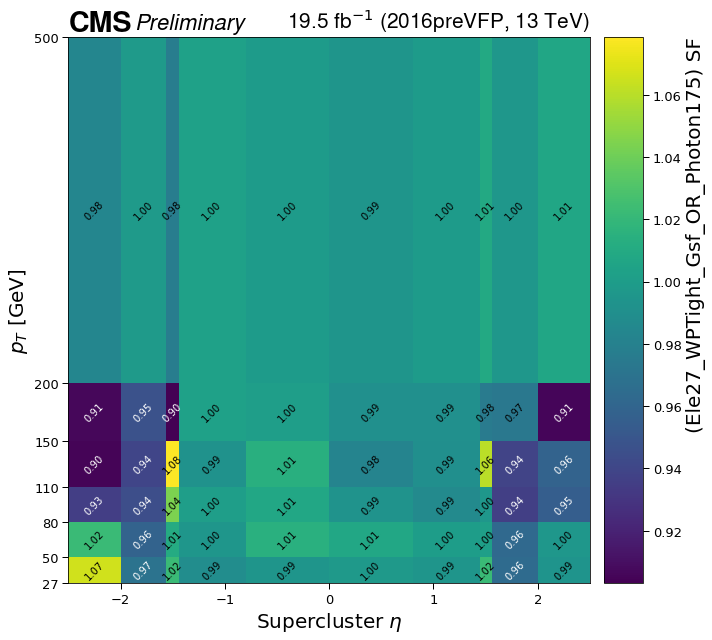

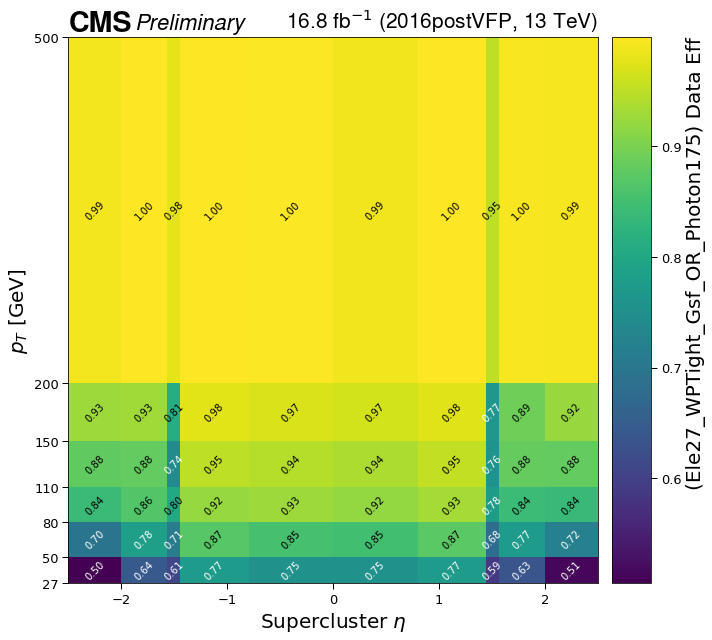

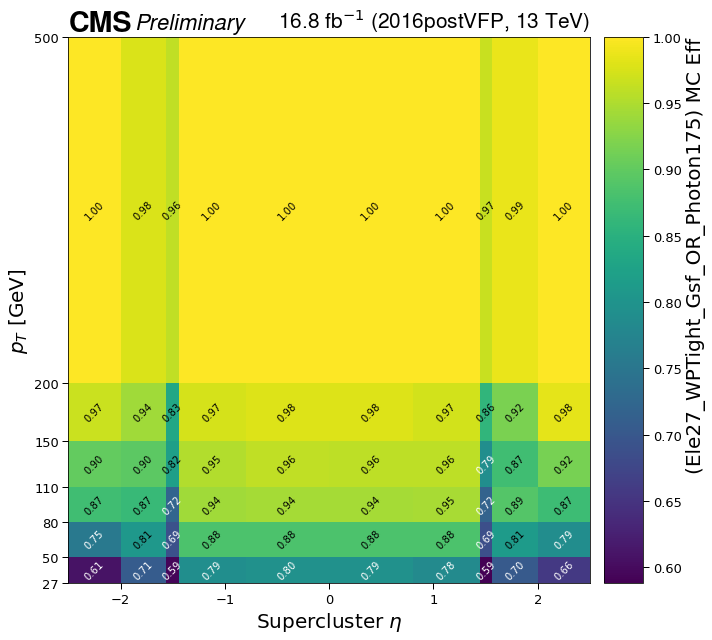

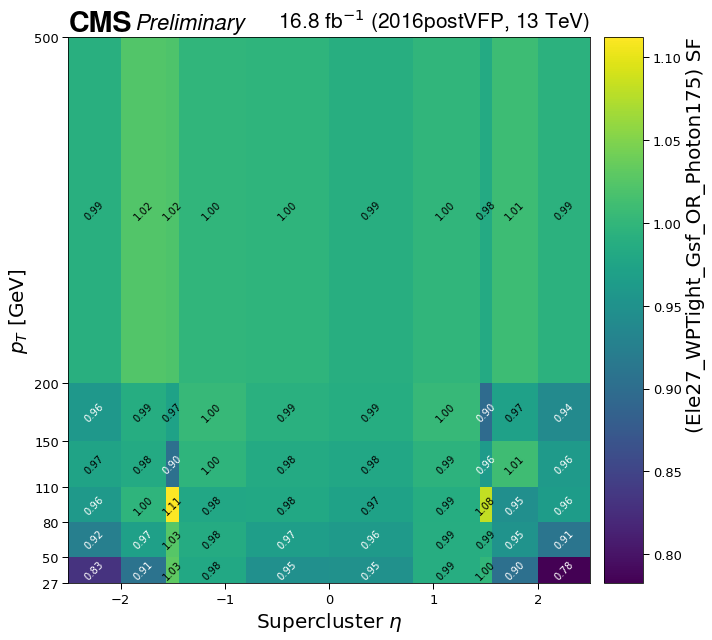

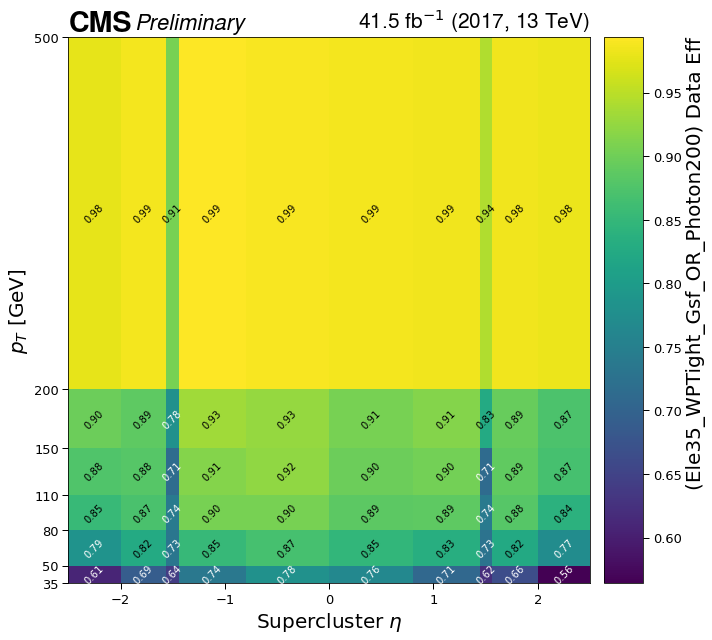

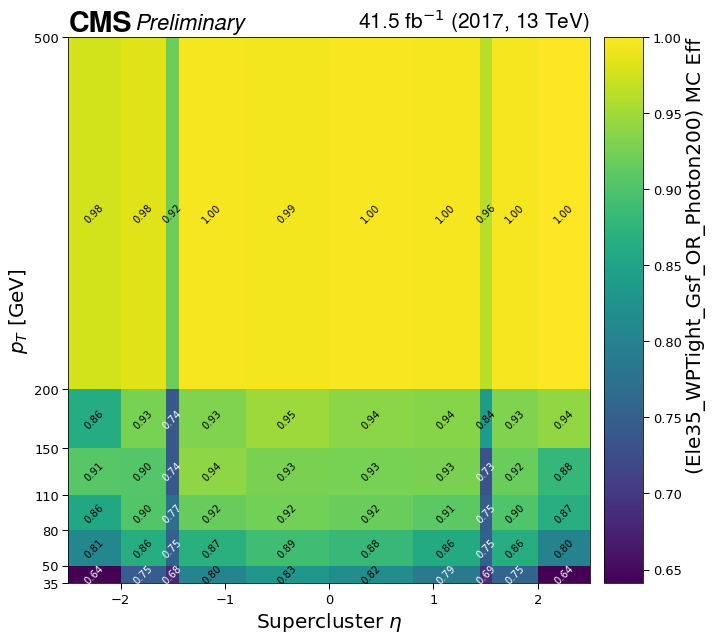

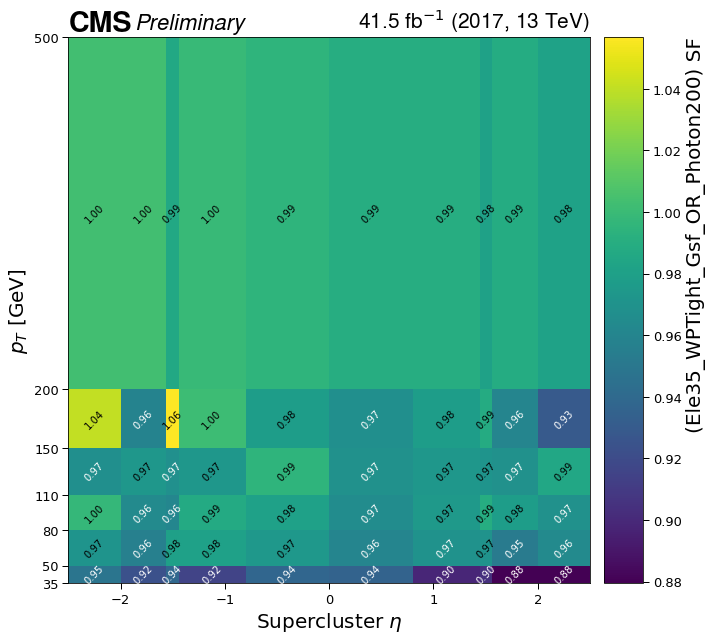

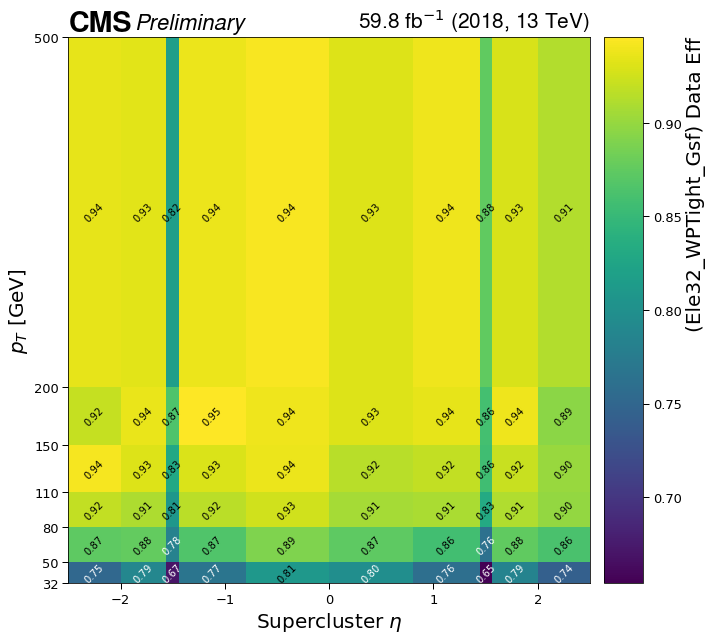

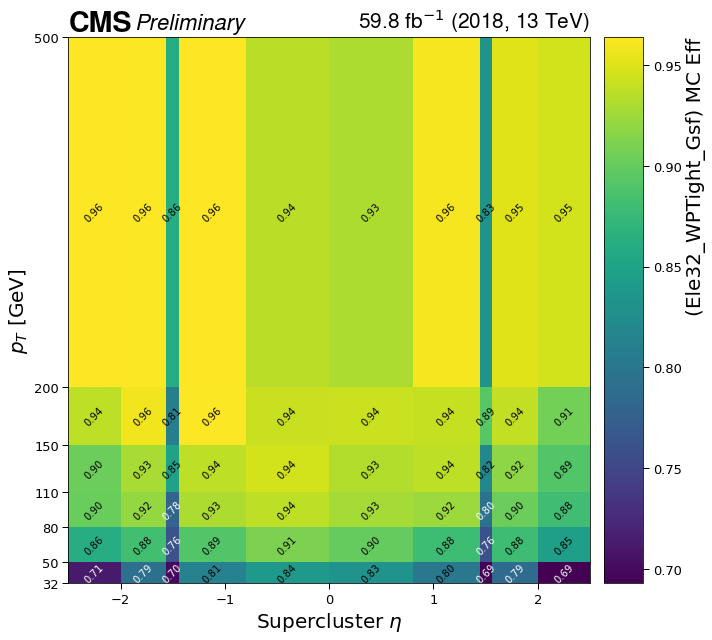

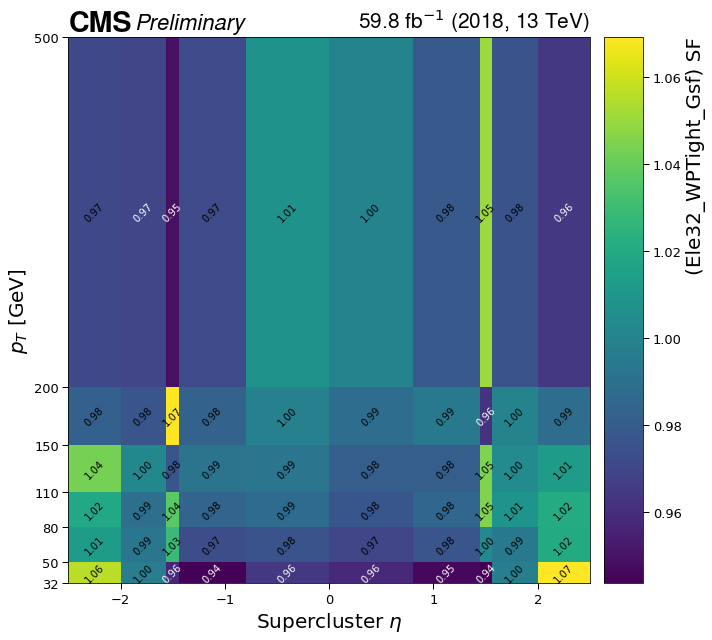

In [2]:
hlt_paths = {
    "2016preVFP": "Ele27_WPTight_Gsf_OR_Photon175",
    "2016postVFP": "Ele27_WPTight_Gsf_OR_Photon175",
    "2017": "Ele35_WPTight_Gsf_OR_Photon200",
    "2018": "Ele32_WPTight_Gsf",
}


def add_text(histogram, ax, threshold):
    matrix = histogram.values()
    pt_centers = histogram.axes[0].centers
    eta_centers = histogram.axes[1].centers
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            x = pt_centers[i]
            y = eta_centers[j]
            if val < threshold or np.isnan(val):
                col = "w"
            else:
                col = "k"
            ax.text(
                x,
                y,
                f"{val:.2f}",
                rotation=45,
                ha="center",
                va="center",
                fontsize=10,
                color=col,
            )


def add_info(year, ax):
    with open("../analysis/postprocess/luminosity.yaml", "r") as f:
        lumi = yaml.safe_load(f)
    hep.cms.lumitext(
        f"{lumi[year] * 1e-3:.1f} fb$^{{-1}}$ ({year}, 13 TeV)", ax=ax, fontsize=22
    )
    hep.cms.text("Preliminary", fontsize=22, ax=ax)
    ax.set_xlabel("Supercluster $\eta$", fontsize=20)
    ax.set_ylabel("$p_T$ [GeV]", fontsize=20)


def plot_sf(sf_hist, year, threshold=0.97):
    fig, ax = plt.subplots(figsize=(10, 9), tight_layout=True)
    colormesh = sf_hist.plot2d(ax=ax)
    colormesh[1].set_label(f"({hlt}) SF", loc="top", fontsize=20)
    add_info(year, ax)
    add_text(sf_hist, ax, threshold)
    fig.savefig(f"{year}_{hlt}_SF.pdf")


def plot_eff(eff_hist, year, is_mc=True, threshold=0.8):
    kind = "MC" if is_mc else "Data"
    fig, ax = plt.subplots(figsize=(10, 9), tight_layout=True)
    colormesh = eff_hist.plot2d(ax=ax)
    colormesh[1].set_label(f"({hlt}) {kind} Eff", loc="top", fontsize=20)
    add_info(year, ax)
    add_text(eff_hist, ax, threshold)
    fig.savefig(f"{year}_{hlt}_{kind.lower()}Eff.pdf")


for year, hlt in hlt_paths.items():
    tree = uproot.open(f"../analysis/data/egammaEffi_EGM2D_{year}.root")
    sfhist = tree["EGamma_SF2D"].to_hist()
    data_effhist = tree["EGamma_EffData2D"].to_hist()
    mc_effhist = tree["EGamma_EffMC2D"].to_hist()

    plot_eff(data_effhist, year, is_mc=False)
    plot_eff(mc_effhist, year, is_mc=True)
    plot_sf(sfhist, year)

In [3]:
for year, hlt in hlt_paths.items():
    print(year.upper())
    tree = uproot.open(f"../analysis/data/egammaEffi_EGM2D_{year}.root")

    # save HLT scale factors to correctionlib object
    sfhist = tree['EGamma_SF2D;1'].to_hist()
    sfhist.name = f"HLT_SF_{hlt}_MVAiso80ID"
    sfhist.label = "out"
    hlt_sf = correctionlib.convert.from_histogram(sfhist)
    hlt_sf.description = f"These are the electron {hlt} scale factors (nominal) for the MVAiso80ID WP and {year} dataset. They are dependent on the transverse momenta and supercluster pseudorapidity of the electron."
    hlt_sf.data.flow = "clamp"
    rich.print(hlt_sf)
    cset = correctionlib.schemav2.CorrectionSet(
        schema_version=2,
        description=f"HLT_SF_{hlt}_MVAiso80ID",
        corrections=[
            hlt_sf
        ],
    )
    with gzip.open(f"../analysis/data/EGamma_HLT_SF_{year}.json.gz", "wt") as fout:
        fout.write(cset.json(exclude_unset=True))

    # save Data/MC HLT efficiencies to correctionlib object
    for key in ["Data", "MC"]:
        effhist = tree[f'EGamma_Eff{key}2D;1'].to_hist()
        effhist.name = f"HLT_{key}Eff_{hlt}_MVAiso80ID"
        effhist.label = "out"
        hlt_eff = correctionlib.convert.from_histogram(effhist)
        hlt_eff.description = f"These are the electron {hlt} efficiencies in {key} (nominal) for the MVAiso80ID WP and {year} dataset. They are dependent on the transverse momenta and supercluster pseudorapidity of the electron."
        hlt_eff.data.flow = "clamp"
        rich.print(hlt_eff)
        cset = correctionlib.schemav2.CorrectionSet(
            schema_version=2,
            description=f"HLT_{key}Eff_{hlt}_MVAiso80ID",
            corrections=[
                hlt_eff
            ],
        )
        with gzip.open(f"../analysis/data/EGamma_HLT_{key}Eff_{year}.json.gz", "wt") as fout:
            fout.write(cset.json(exclude_unset=True))

2016PREVFP


📈 HLT_SF_Ele27_WPTight_Gsf_OR_Photon175_MVAiso80ID (v0)
These are the electron Ele27_WPTight_Gsf_OR_Photon175 scale factors (nominal) for the MVAiso80ID WP and 2016preVFP 
dataset. They are dependent on the transverse momenta and supercluster pseudorapidity of the electron.
Node counts: MultiBinning: 1
╭──────────── ▶ input ────────────╮ ╭───────────── ▶ input ─────────────╮
│ xaxis (real)                    │ │ yaxis (real)                      │
│ SuperCluster #eta               │ │ p_{T} [GeV]                       │
│ Range: [-2.5, 2.5), overflow ok │ │ Range: [27.0, 500.0), overflow ok │
╰─────────────────────────────────╯ ╰───────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

📈 HLT_DataEff_Ele27_WPTight_Gsf_OR_Photon175_MVAiso80ID (v0)
These are the electron Ele27_WPTight_Gsf_OR_Photon175 efficiencies in Data (nominal) for the MVAiso80ID WP and 
2016preVFP dataset. They are dependent on the transverse momenta and supercluster pseudorapidity of the electron.
Node counts: MultiBinning: 1
╭──────────── ▶ input ────────────╮ ╭───────────── ▶ input ─────────────╮
│ xaxis (real)                    │ │ yaxis (real)                      │
│ SuperCluster #eta               │ │ p_{T} [GeV]                       │
│ Range: [-2.5, 2.5), overflow ok │ │ Range: [27.0, 500.0), overflow ok │
╰─────────────────────────────────╯ ╰───────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

📈 HLT_MCEff_Ele27_WPTight_Gsf_OR_Photon175_MVAiso80ID (v0)
These are the electron Ele27_WPTight_Gsf_OR_Photon175 efficiencies in MC (nominal) for the MVAiso80ID WP and 
2016preVFP dataset. They are dependent on the transverse momenta and supercluster pseudorapidity of the electron.
Node counts: MultiBinning: 1
╭──────────── ▶ input ────────────╮ ╭───────────── ▶ input ─────────────╮
│ xaxis (real)                    │ │ yaxis (real)                      │
│ SuperCluster #eta               │ │ p_{T} [GeV]                       │
│ Range: [-2.5, 2.5), overflow ok │ │ Range: [27.0, 500.0), overflow ok │
╰─────────────────────────────────╯ ╰───────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

2016POSTVFP


📈 HLT_SF_Ele27_WPTight_Gsf_OR_Photon175_MVAiso80ID (v0)
These are the electron Ele27_WPTight_Gsf_OR_Photon175 scale factors (nominal) for the MVAiso80ID WP and 2016postVFP
dataset. They are dependent on the transverse momenta and supercluster pseudorapidity of the electron.
Node counts: MultiBinning: 1
╭──────────── ▶ input ────────────╮ ╭───────────── ▶ input ─────────────╮
│ xaxis (real)                    │ │ yaxis (real)                      │
│ SuperCluster #eta               │ │ p_{T} [GeV]                       │
│ Range: [-2.5, 2.5), overflow ok │ │ Range: [27.0, 500.0), overflow ok │
╰─────────────────────────────────╯ ╰───────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

📈 HLT_DataEff_Ele27_WPTight_Gsf_OR_Photon175_MVAiso80ID (v0)
These are the electron Ele27_WPTight_Gsf_OR_Photon175 efficiencies in Data (nominal) for the MVAiso80ID WP and 
2016postVFP dataset. They are dependent on the transverse momenta and supercluster pseudorapidity of the electron.
Node counts: MultiBinning: 1
╭──────────── ▶ input ────────────╮ ╭───────────── ▶ input ─────────────╮
│ xaxis (real)                    │ │ yaxis (real)                      │
│ SuperCluster #eta               │ │ p_{T} [GeV]                       │
│ Range: [-2.5, 2.5), overflow ok │ │ Range: [27.0, 500.0), overflow ok │
╰─────────────────────────────────╯ ╰───────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

📈 HLT_MCEff_Ele27_WPTight_Gsf_OR_Photon175_MVAiso80ID (v0)
These are the electron Ele27_WPTight_Gsf_OR_Photon175 efficiencies in MC (nominal) for the MVAiso80ID WP and 
2016postVFP dataset. They are dependent on the transverse momenta and supercluster pseudorapidity of the electron.
Node counts: MultiBinning: 1
╭──────────── ▶ input ────────────╮ ╭───────────── ▶ input ─────────────╮
│ xaxis (real)                    │ │ yaxis (real)                      │
│ SuperCluster #eta               │ │ p_{T} [GeV]                       │
│ Range: [-2.5, 2.5), overflow ok │ │ Range: [27.0, 500.0), overflow ok │
╰─────────────────────────────────╯ ╰───────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

2017


📈 HLT_SF_Ele35_WPTight_Gsf_OR_Photon200_MVAiso80ID (v0)
These are the electron Ele35_WPTight_Gsf_OR_Photon200 scale factors (nominal) for the MVAiso80ID WP and 2017 
dataset. They are dependent on the transverse momenta and supercluster pseudorapidity of the electron.
Node counts: MultiBinning: 1
╭──────────── ▶ input ────────────╮ ╭───────────── ▶ input ─────────────╮
│ xaxis (real)                    │ │ yaxis (real)                      │
│ SuperCluster #eta               │ │ p_{T} [GeV]                       │
│ Range: [-2.5, 2.5), overflow ok │ │ Range: [35.0, 500.0), overflow ok │
╰─────────────────────────────────╯ ╰───────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

📈 HLT_DataEff_Ele35_WPTight_Gsf_OR_Photon200_MVAiso80ID (v0)
These are the electron Ele35_WPTight_Gsf_OR_Photon200 efficiencies in Data (nominal) for the MVAiso80ID WP and 2017
dataset. They are dependent on the transverse momenta and supercluster pseudorapidity of the electron.
Node counts: MultiBinning: 1
╭──────────── ▶ input ────────────╮ ╭───────────── ▶ input ─────────────╮
│ xaxis (real)                    │ │ yaxis (real)                      │
│ SuperCluster #eta               │ │ p_{T} [GeV]                       │
│ Range: [-2.5, 2.5), overflow ok │ │ Range: [35.0, 500.0), overflow ok │
╰─────────────────────────────────╯ ╰───────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

📈 HLT_MCEff_Ele35_WPTight_Gsf_OR_Photon200_MVAiso80ID (v0)
These are the electron Ele35_WPTight_Gsf_OR_Photon200 efficiencies in MC (nominal) for the MVAiso80ID WP and 2017 
dataset. They are dependent on the transverse momenta and supercluster pseudorapidity of the electron.
Node counts: MultiBinning: 1
╭──────────── ▶ input ────────────╮ ╭───────────── ▶ input ─────────────╮
│ xaxis (real)                    │ │ yaxis (real)                      │
│ SuperCluster #eta               │ │ p_{T} [GeV]                       │
│ Range: [-2.5, 2.5), overflow ok │ │ Range: [35.0, 500.0), overflow ok │
╰─────────────────────────────────╯ ╰───────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

2018


📈 HLT_SF_Ele32_WPTight_Gsf_MVAiso80ID (v0)
These are the electron Ele32_WPTight_Gsf scale factors (nominal) for the MVAiso80ID WP and 2018 dataset. They are 
dependent on the transverse momenta and supercluster pseudorapidity of the electron.
Node counts: MultiBinning: 1
╭──────────── ▶ input ────────────╮ ╭───────────── ▶ input ─────────────╮
│ xaxis (real)                    │ │ yaxis (real)                      │
│ SuperCluster #eta               │ │ p_{T} [GeV]                       │
│ Range: [-2.5, 2.5), overflow ok │ │ Range: [32.0, 500.0), overflow ok │
╰─────────────────────────────────╯ ╰───────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

📈 HLT_DataEff_Ele32_WPTight_Gsf_MVAiso80ID (v0)
These are the electron Ele32_WPTight_Gsf efficiencies in Data (nominal) for the MVAiso80ID WP and 2018 dataset. 
They are dependent on the transverse momenta and supercluster pseudorapidity of the electron.
Node counts: MultiBinning: 1
╭──────────── ▶ input ────────────╮ ╭───────────── ▶ input ─────────────╮
│ xaxis (real)                    │ │ yaxis (real)                      │
│ SuperCluster #eta               │ │ p_{T} [GeV]                       │
│ Range: [-2.5, 2.5), overflow ok │ │ Range: [32.0, 500.0), overflow ok │
╰─────────────────────────────────╯ ╰───────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

📈 HLT_MCEff_Ele32_WPTight_Gsf_MVAiso80ID (v0)
These are the electron Ele32_WPTight_Gsf efficiencies in MC (nominal) for the MVAiso80ID WP and 2018 dataset. They 
are dependent on the transverse momenta and supercluster pseudorapidity of the electron.
Node counts: MultiBinning: 1
╭──────────── ▶ input ────────────╮ ╭───────────── ▶ input ─────────────╮
│ xaxis (real)                    │ │ yaxis (real)                      │
│ SuperCluster #eta               │ │ p_{T} [GeV]                       │
│ Range: [-2.5, 2.5), overflow ok │ │ Range: [32.0, 500.0), overflow ok │
╰─────────────────────────────────╯ ╰───────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯